<img src="http://drive.google.com/uc?export=view&id=1RJUAUMmViCsYSgyFj7oyqBu4c6AZMeFR">

T-Maze problem was designed to test Reinforcement Learning-LSTM's capability to bridge long time lags, without confounding the results by making the control task difficult in other ways [(Bakker, 2002)](http://papers.nips.cc/paper/1953-reinforcement-learning-with-long-short-term-memory.pdf]). However, we can also use this test-bed for supervised algorithms by exploiting the gold actions.

In the T-Maze problem, the agent has four possible actions: move North, East, South, or West. The agent must learn to move from the starting position at the beginning of the corridor to the T-junction. There it must move either North or South to a changing goal position, which it cannot see. However, the location of the goal depends on a "road sign" the agent has seen at the starting position. At the starting position, the observation is either 011 (North) or 110 (South), in the corridor the observation is 101, and at the T-junction the observation is 010.

In this assignment, you will complete lstm based architecture, train and test the model on different settings to inspect the learning curve and generalization power of the model. You will also explore the behavior of the model by visualizing hidden and cell vectors, and weights.

In [1]:
#Name: Duygu Sezen Islakoğlu

In [2]:
using Pkg;

# Install missing packages
for p in ["Knet", "Luxor", "Plots"]
    if !haskey(Pkg.installed(),p)
        Pkg.add(p);
    end
end

using Knet, Luxor, Plots, Random, Printf

In [3]:
mutable struct TMaze
    length::Int
    goal::Int # 0 = North, 1 = South
    agent_position::Tuple{Int,Int} # Agent's current position (x, y)
end

function get_state(maze::TMaze)
    """
    Returns the current state
    """
    
    state = zeros(Float32, 3,)
    
    if maze.agent_position[1] == maze.length # At the T-junction
        state[2] = 1.0
    elseif maze.agent_position[1] == 0 # At the start position
        if maze.goal == 0
            state[2] = 1.0
            state[3] = 1.0
        else
            state[1] = 1.0
            state[2] = 1.0
        end
    else # In the corridor
        state[1] = 1.0
        state[3] = 1.0
    end
    return state
end

function step(maze::TMaze, action::Int)
    """
    Gets action and plays one step. If the resulted state is the final state
    then it checks whether it is the goal state or not. If it is a goal state
    and the correct one it returns 1, if it is wrong it returns -1.
    If the resulted state is not the final state, then it returns 0.
    1 : North
    2 : East
    3 : South
    4 : West
    """
    p = maze.agent_position
    res = 0
    
    if p[1] == maze.length && p[2] == 0
        if action == 1
            maze.agent_position = (p[1], min(-1, p[2]-1))
            res = maze.goal == 0 ? 1 : -1
        elseif action == 3
            maze.agent_position = (p[1], min(1, p[2]+1))
            res = maze.goal == 0 ? -1 : 1
        elseif action == 4
            maze.agent_position = (p[1]-1, 0)
        end
    elseif p[1] != maze.length && action == 2
        maze.agent_position = (p[1]+1, 0)
    elseif p[1] != maze.length && action == 4
        maze.agent_position = (min(p[1]-1, 0), 0)
    end
    return res
end

function get_gold_actions(maze::TMaze)
    """
    Returns a vector of integer for gold actions
    """
    
    gold_actions = ones(Int, maze.length) * 2
    push!(gold_actions, maze.goal == 0 ? 1 : 3)
    return gold_actions
end

function get_supervised_states(maze::TMaze)
    """
    Returns the list of states for the gold actions.
    The list includes the starting position, but does not include the final state.
    """
    
    p = maze.agent_position # store the agent position
    
    maze.agent_position = (0, 0)
    
    states = []
    for action in get_gold_actions(maze)
        push!(states, get_state(maze))
        step(maze, action)
    end
    
    maze.agent_position = p # reset
    return states
end

function draw(maze::TMaze)
    dim = 500 / (2 * (maze.length +1))
    Drawing(500, round(Int, dim*3))
    origin()
    background("white")
    sethue("black")
    box.([O + (i*dim, 0) for i=0:maze.length], dim, dim, :stroke)
    if maze.goal == 0
        sethue("crimson")
        box.(O + (maze.length*dim, -dim), dim, dim, :fill)
        sethue("black")
        box.(O + (maze.length*dim, dim), dim, dim, :stroke)
        if maze.agent_position[1] == 0
            Luxor.arrow(O + (0, -dim*0.65), Point(0, -dim*1.45))
        end
    else
        sethue("crimson")
        box.(O + (maze.length*dim, dim), dim, dim, :fill)
        sethue("black")
        box.(O + (maze.length*dim, -dim), dim, dim, :stroke)
        if maze.agent_position[1] == 0
            Luxor.arrow(O + (0, dim*0.65), Point(0, dim*1.45))
        end
    end
    sethue("steelblue4")
    circle(O + (maze.agent_position[1]*dim,maze.agent_position[2]*dim), dim*0.45, :fill)
    finish()
    preview()
end

draw (generic function with 1 method)

In [4]:
atype =  Float32

Float32

In [5]:
maze = TMaze(5,1,(0,0));

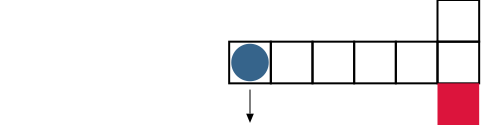

In [6]:
draw(maze)

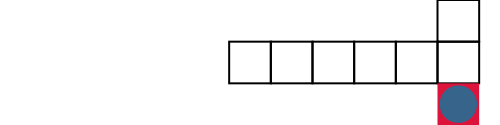

Action: 3
Result: 1

In [7]:
maze2 = TMaze(5,1,(0,0));
draw(maze2)  
sleep(1)

#Let's animate
for action in get_gold_actions(maze2)
    res = step(maze2, action)
    draw(maze2)    
    print("Action: $action\n")
    print("Result: $res")
    sleep(1) # sleep 1 second
end

In [8]:
get_gold_actions(maze)

6-element Array{Int64,1}:
 2
 2
 2
 2
 2
 3

In [9]:
get_supervised_states(maze)

6-element Array{Any,1}:
 Float32[1.0, 1.0, 0.0]
 Float32[1.0, 0.0, 1.0]
 Float32[1.0, 0.0, 1.0]
 Float32[1.0, 0.0, 1.0]
 Float32[1.0, 0.0, 1.0]
 Float32[0.0, 1.0, 0.0]

In [10]:
function get_all_data_up_to(N::Int)
    """
    Generates a list of tuples, where each tuple contains supervised states
    and gold actions for a specific configuration. There are 2N tuples in the
    list.
    """
    data = []
    for i=1:N
        for goal in [0, 1]
            maze = TMaze(i,goal,(0,0));
            states = get_supervised_states(maze)
            actions = get_gold_actions(maze)
            push!(data, (states, actions))
        end
    end
    return data
end

get_all_data_up_to (generic function with 1 method)

In [11]:
data = get_all_data_up_to(3)

6-element Array{Any,1}:
 (Any[Float32[0.0, 1.0, 1.0], Float32[0.0, 1.0, 0.0]], [2, 1])                                                      
 (Any[Float32[1.0, 1.0, 0.0], Float32[0.0, 1.0, 0.0]], [2, 3])                                                      
 (Any[Float32[0.0, 1.0, 1.0], Float32[1.0, 0.0, 1.0], Float32[0.0, 1.0, 0.0]], [2, 2, 1])                           
 (Any[Float32[1.0, 1.0, 0.0], Float32[1.0, 0.0, 1.0], Float32[0.0, 1.0, 0.0]], [2, 2, 3])                           
 (Any[Float32[0.0, 1.0, 1.0], Float32[1.0, 0.0, 1.0], Float32[1.0, 0.0, 1.0], Float32[0.0, 1.0, 0.0]], [2, 2, 2, 1])
 (Any[Float32[1.0, 1.0, 0.0], Float32[1.0, 0.0, 1.0], Float32[1.0, 0.0, 1.0], Float32[0.0, 1.0, 0.0]], [2, 2, 2, 3])

Unrolled lstm for the action prediction:

<p align="center">
    <img src="http://drive.google.com/uc?export=view&id=1icpMxPC3q6p-9ABWQfIg4R7dRQ6_MWar">
</p>

## Problem 1. Implement the LSTM Agent
You need to implement initweights function which takes hidden, world size and number of actions, and returns the whole model as `Array{Any}` julia data type.

In [12]:
# model definition

struct Linear
    w
    b
end

# Initializer for a softmax classifier
function Linear(num_inputs::Int, num_outputs::Int, init=gaussian)
    # START YOUR ANSWER
    Linear(param((num_outputs,num_inputs);init=init), 
       param0(num_outputs))
    # END YOUR ANSWER
end

function (l::Linear)(x)
    # START YOUR ANSWER
    l.w * x .+ l.b
    # END YOUR ANSWER
end

struct LSTMNet
    w
    b
end

# Hint you mave take a look main function below to better understand its calling convention
# Remember that, forget gate bias should be ones instead of zeros
function LSTMNet(num_inputs::Int, hidden_size::Int, init=gaussian)
    # START YOUR ANSWER
    b = zeros(4*hidden_size)
    b[1:hidden_size] += ones(hidden_size)
    LSTMNet(param(4 * hidden_size, hidden_size + num_inputs; init=init),
        param(b))
    # END YOUR ANSWER
end

# lstm procedure is given to you
# weight * input .+ bias, concatenated weights for computational efficiency
# You should use this function in your LSTM module call
function lstm(weight, bias, hidden, cell, input)
    gates   = weight * vcat(hidden,input) .+ bias
    hsize   = size(hidden,1)
    forget  = sigm.(gates[1:hsize,:])
    ingate  = sigm.(gates[1+hsize:2hsize,:])
    outgate = sigm.(gates[1+2hsize:3hsize,:])
    change  = tanh.(gates[1+3hsize:end,:])
    cell    = cell .* forget + ingate .* change
    hidden  = outgate .* tanh.(cell)
    return (hidden, cell)
end

function (l::LSTMNet)(x, prev_hidden, prev_cell)
    # START YOUR ANSWER
    hidden, cell = lstm(l.w, l.b, prev_hidden, prev_cell, x)
    return (hidden, cell)
    # END YOUR ANSWER
end

mutable struct LSTMAgent
    lstm::LSTMNet # a lstm network
    linear::Linear # a linear layer on top of the lstm network
    state # Array{Any}(undef, 2) for hidden and cell states
end

function LSTMAgent(hidden_size::Int, world_dim::Int=3, num_actions::Int=4)
    # START YOUR ANSWER
    LSTMAgent(LSTMNet(world_dim, hidden_size),
          Linear(hidden_size, num_actions),
          [zeros(hidden_size), zeros(hidden_size)])
    # END YOUR ANSWER
end

# resets the hidden and cell states
function reset!(model::LSTMAgent)
    # START YOUR ANSWER
    model.state = [zeros(size(model.state[1])),
                   zeros(size(model.state[2]))]
    # END YOUR ANSWER
end

# before calling the model you should reset the hidden and cell states
# model gets world state(s) and applies the lstm function to each state in the world_states
# and predicts a score vector for actions.
function (model::LSTMAgent)(world_states)
    scores = []
    # START YOUR ANSWER
    reset!(model)
    
    hidden, cell= model.state

    for i in world_states
        hidden, cell = model.lstm(i, hidden, cell)
        model.state = [hidden, cell]
        push!(scores, model.linear(model.state[1]))
    end
    
    # END YOUR ANSWER
    return scores
end

## Problem 2. Implement Loss function
That function basically takes the predictions and returns the negative log-likelihood of these predictions as loss.
Hint: You may have a look Knet's ```nll``` function

In [13]:
# our loss function
# hint: use nll function (type @doc nll in an another cell)
function loss(model, world_states, gold_actions)
    total = 0.0
    scores = model(world_states)

    # START ANSWER
    s = zeros(size(scores[1],1), size(scores,1))
    for i in 1:length(scores)
        total += nll(scores[i], [gold_actions[i]])
    end
    # END ANSWER
    
    lossval = total/length(gold_actions)
    return lossval
end

loss (generic function with 1 method)

In [14]:
?nll

search: nll finally C_NULL devnull findall UnionAll sequential_palette



```
nll(scores, answers; dims=1, average=true)
```

Given an unnormalized `scores` matrix and an `Integer` array of correct `answers`, return the negative log likelihood. The `scores` matrix should have size (classes,instances) if `dims=1` or (instances,classes) if `dims=2`. `answers[i]` should be in `1:classes` to indicate the correct class for instance i, or 0 to skip instance i. The return value is `(total/count)` if `average=true` and `(total,count)` if `average=false` where `count` is the number of instances not skipped and `total` is their total negative log likelihood.

## Example

Let's assume that there are three classes (cat, dog, ostrich) and just 2 instances with the unnormalized score `scores[:,1]` and `scores[:,2]` respectively. The first instance is actually a cat and the second instance a dog:

```julia
scores = [12.2    0.3;
           2.0   21.5;
           0.0  -21.0]
answers = [1, 2]
Knet.nll(scores,answers)
# returns 2.1657e-5
```

The probabilites are derived from the scores and the log-probabilities corresponding to the answers are averaged:

```julia
probabilites = exp.(scores) ./ sum(exp.(scores),dims=1)
nnl = -(log(probabilites[answers[1],1]) + log(probabilites[answers[2],2]))/2
# returns 2.1657e-5
```

---

```
nll(model, data; dims=1, average=true, o...)
```

Compute negative log likelihood `nll(model(x; o...), y; dims)` for `(x,y)` in `data` and return `(total/count)` if `average=true` or `(total,count)` if `average=false`.


In [15]:
function train!(model, world_states, gold_actions)
    L = @diff loss(model, world_states, gold_actions)
    for p in params(model)
        g = grad(L, p)
        update!(value(p), g, p.opt)
    end
    return value(L)
end

train! (generic function with 1 method)

In [16]:
?argmax

search: argmax



```
argmax(itr) -> Integer
```

Return the index of the maximum element in a collection. If there are multiple maximal elements, then the first one will be returned.

The collection must not be empty.

# Examples

```jldoctest
julia> argmax([8,0.1,-9,pi])
1

julia> argmax([1,7,7,6])
2

julia> argmax([1,7,7,NaN])
4
```

---

```
argmax(A; dims) -> indices
```

For an array input, return the indices of the maximum elements over the given dimensions. `NaN` is treated as greater than all other values.

# Examples

```jldoctest
julia> A = [1.0 2; 3 4]
2×2 Array{Float64,2}:
 1.0  2.0
 3.0  4.0

julia> argmax(A, dims=1)
1×2 Array{CartesianIndex{2},2}:
 CartesianIndex(2, 1)  CartesianIndex(2, 2)

julia> argmax(A, dims=2)
2×1 Array{CartesianIndex{2},2}:
 CartesianIndex(1, 2)
 CartesianIndex(2, 2)
```


## Problem 3. Implement Accuracy function
Accuracy function checks each predicted action for a path and counts correct if all predictions are correct for a path. This function does not calculate the mean accuracy for the data, instead it returns a list storing accuracy of each path.

In [17]:
# possible helpful procedures: argmax, vec
function path_accuracy(model, data)
    accuracies = []
    for (world_states, gold_actions) in data
        ncorrect = 0
        reset!(model)
        scores = model(world_states)
        #ncorrect must be equal to the path length (i.e. length of the gold actions)
        
        # START ANSWER
        for i in 1:length(scores)
            pred = argmax(scores[i])
            gold = gold_actions[i]
            
            if pred[1] == gold
                ncorrect = ncorrect + 1
            end
        end
        # END ANSWER
        
        push!(accuracies, ncorrect == length(gold_actions) ? 1.0 : 0.0)
    end

    return accuracies
end

path_accuracy (generic function with 1 method)

In [18]:
function train_until_all_success(model, data; maxe=50000)
    """
    Gets model parameters w, initial states s, optimizers opt and data.
    It trains the model untill the accuracy on the data reach to 1.0.
    """
    experiment = []
    for i=1:maxe
        world_states, gold_actions = rand(data) #sample data
        reset!(model)
        train!(model, world_states, gold_actions)
        
        accuracies = path_accuracy(model, data)
        total = sum(accuracies)/length(accuracies)
        push!(experiment, total)
        print("\r Number of Instances: $i Acc: $(@sprintf("%.3f", total))")
        if total == 1.0
            break
        end
    end
    return experiment
end

train_until_all_success (generic function with 1 method)

In [19]:
data = get_all_data_up_to(10);

In [20]:
Knet.seed!(123456)

HIDDEN = 4

model_4 = LSTMAgent(HIDDEN)
for p in params(model_4)
    p.opt = Adam()
end

Random.seed!(123456)
hidden_4 = train_until_all_success(model_4, data; maxe=100000);

 Number of Instances: 13720 Acc: 0.500

Excessive output truncated after 524364 bytes.

 Number of Instances: 13728 Acc: 0.500

In [21]:
Knet.seed!(123456)

HIDDEN = 8

model_8 = LSTMAgent(HIDDEN)
for p in params(model_8)
    p.opt = Adam()
end

Random.seed!(123456)
hidden_8 = train_until_all_success(model_8, data; maxe=100000);

 Number of Instances: 13720 Acc: 0.550

Excessive output truncated after 524364 bytes.

 Number of Instances: 13728 Acc: 0.500

In [22]:
Knet.seed!(123456)

HIDDEN = 16

model_16 = LSTMAgent(HIDDEN)
for p in params(model_16)
    p.opt = Adam()
end

Random.seed!(123456)
hidden_16 = train_until_all_success(model_16, data; maxe=100000);

 Number of Instances: 8750 Acc: 1.000

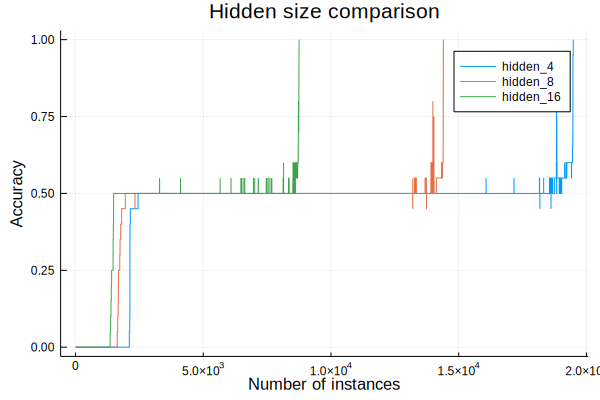

In [23]:
plot([1:length(hidden_4), 1:length(hidden_8), 1:length(hidden_16)],
    [hidden_4, hidden_8, hidden_16],
    label=["hidden_4" "hidden_8" "hidden_16"],
    xlabel="Number of instances", ylabel="Accuracy", title="Hidden size comparison")

In [24]:
limit = 50
test_data = get_all_data_up_to(limit);

In [25]:
accuracies = path_accuracy(model_4, test_data)
N_4 = map(x->sum(accuracies[(x-1)*2+1:x*2])/2, 1:limit);

In [26]:
accuracies = path_accuracy(model_8, test_data)
N_8 = map(x->sum(accuracies[(x-1)*2+1:x*2])/2, 1:limit);

In [27]:
accuracies = path_accuracy(model_16, test_data)
N_16 = map(x->sum(accuracies[(x-1)*2+1:x*2])/2, 1:limit);

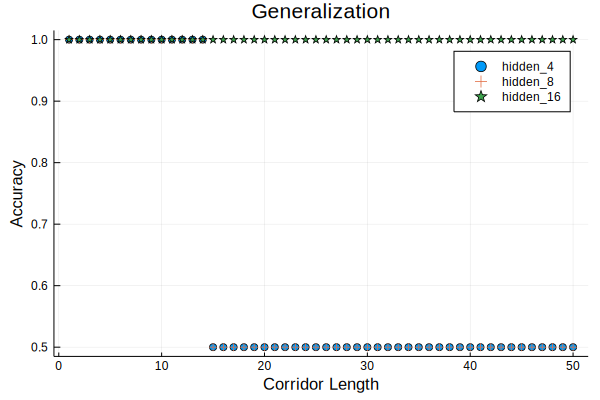

In [28]:
plot([N_4 N_8 N_16], linetype=:scatter, m=[:circle :cross :star5],
    label=["hidden_4" "hidden_8" "hidden_16"],
    xlabel="Corridor Length", ylabel="Accuracy", title="Generalization")

hidden_4 and hidden_8 models can only handle up to corridor length equals to 15. However, hidden_16 is able to solve the task. Let's inspect the behaviour of this model.

## Problem 4. Implement Play function
`play` function gets a maze, trained model parameters w and initial states s. It takes action using the model until either the agent reaches the final state or exceeds the maximum action limit. The function returns the actions taken, hidden and cell states of the lstm.

In [87]:
function play(maze, model; max_actions=20)
    res = 0
    action_count = 0
    hiddens = []
    cells = []
    actions = []
    draw(maze)
    reset!(model)
    # Added
    hidden, cell = model.state
    while !(res != 0 || action_count >= max_actions)
        sleep(1) # sleep 1 second
        x = get_state(maze) # get state
        
        # START ANSWER
        hidden, cell = model.lstm(x, hidden, cell)
        push!(actions, argmax(model.linear(hidden))[1])
        
        action = argmax(model.linear(hidden))[1]
        # END ANSWER
        
        res = step(maze, action) # prediction from the model
        draw(maze)
        action_count += 1
        
        push!(hiddens, hidden)
        push!(cells, cell)
    end
    
    return actions, hiddens, cells
end

play (generic function with 1 method)

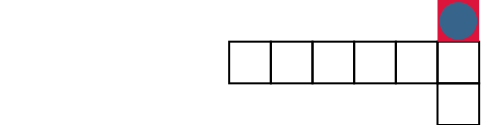

In [88]:
maze = TMaze(5, 0, (0, 0))
actions_0, hiddens_0, cells_0 = play(maze, model_16);

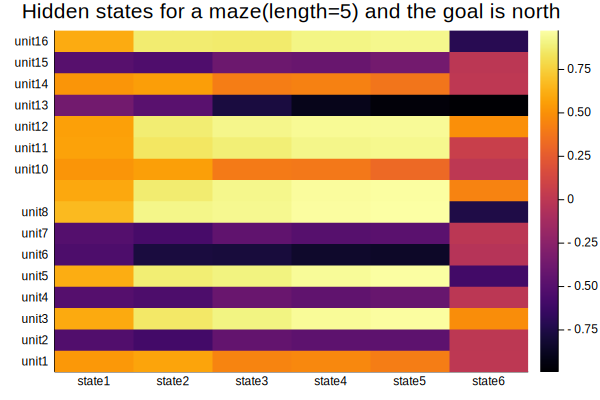

In [89]:
xs = [string("state", i) for i = 1:maze.length+1]
ys = [string("unit", i) for i = 1:16]
heatmap(xs, ys, hcat(hiddens_0...), title="Hidden states for a maze(length=5) and the goal is north")

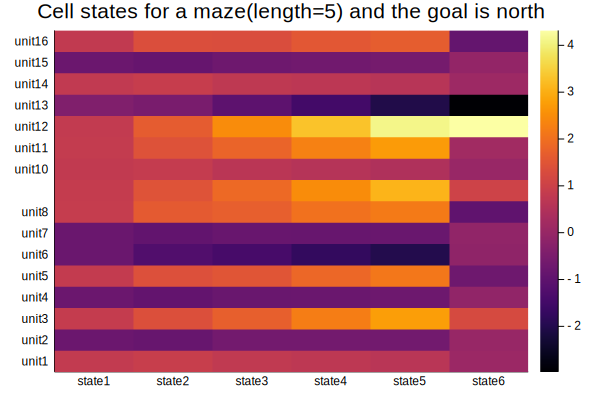

In [90]:
xs = [string("state", i) for i = 1:maze.length+1]
ys = [string("unit", i) for i = 1:16]
heatmap(xs, ys, hcat(cells_0...), title="Cell states for a maze(length=5) and the goal is north")

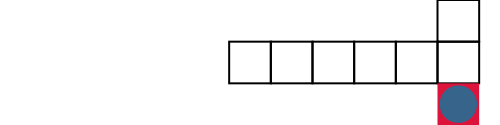

In [91]:
maze = TMaze(5, 1, (0, 0))
actions_1, hiddens_1, cells_1 = play(maze, model_16);

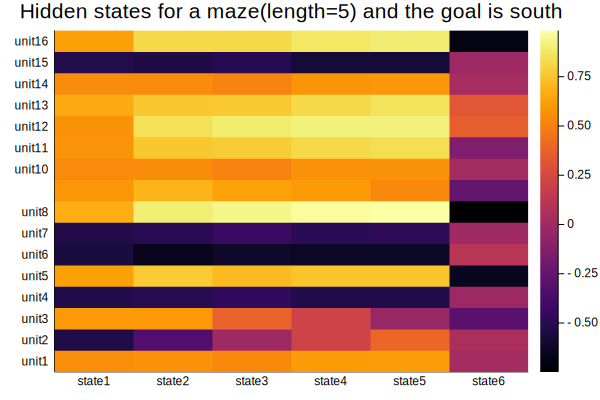

In [92]:
xs = [string("state", i) for i = 1:maze.length+1]
ys = [string("unit", i) for i = 1:16]
heatmap(xs, ys, hcat(hiddens_1...), title="Hidden states for a maze(length=5) and the goal is south")

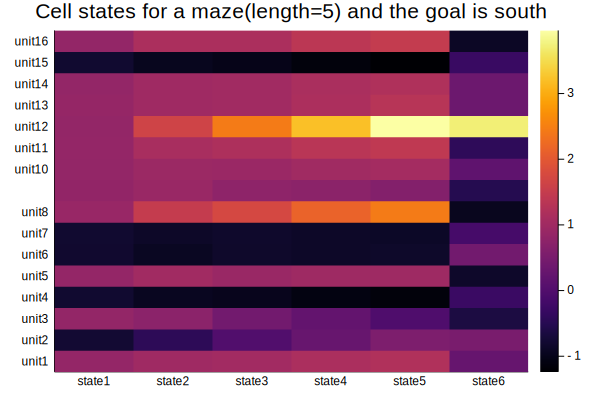

In [93]:
xs = [string("state", i) for i = 1:maze.length+1]
ys = [string("unit", i) for i = 1:16]
heatmap(xs, ys, hcat(cells_1...), title="Cell states for a maze(length=5) and the goal is south")

Until the t-junction, the model preserves the hidden state and at the t-junction it switches hidden state for the final prediction.

## Problem 5. Weight Visualization
Complete following code snippets to visualize weights used for different components in the model. Since each gate has different purpose, inspect each weight and bias vector individually. At the end of the section, give your explanation about obtained results. Use the weights model_16 for hidden size equals to 16.

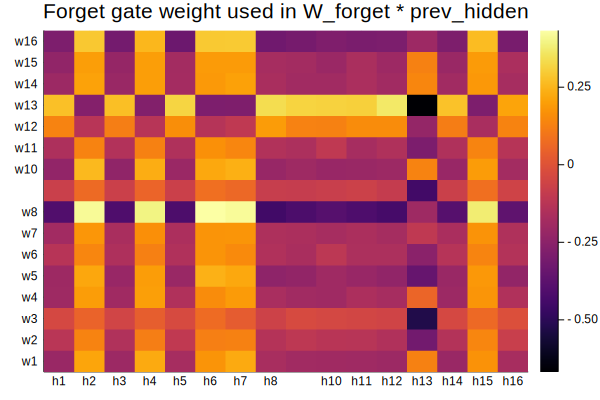

In [108]:
#+
xs = [string("h", i) for i = 1:16]
ys = [string("w", i) for i = 1:16]
heatmap(xs, ys, model_16.lstm.w[1:16,1:16] , title="Forget gate weight used in W_forget * prev_hidden")

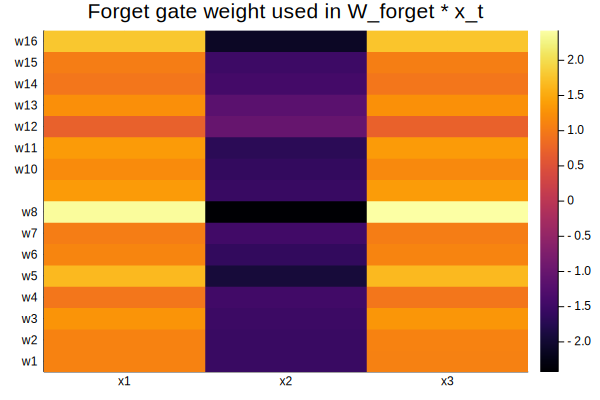

In [136]:
#+
xs = [string("x", i) for i = 1:3]
ys = [string("w", i) for i = 1:16]
heatmap(xs, ys, model_16.lstm.w[1:16, 17:19], title="Forget gate weight used in W_forget * x_t")

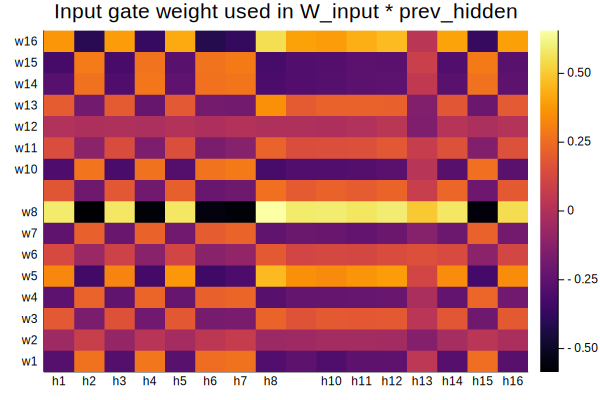

In [114]:
#+
xs = [string("h", i) for i = 1:16]
ys = [string("w", i) for i = 1:16]
heatmap(xs, ys, model_16.lstm.w[16+1:16*2, 1:16], title="Input gate weight used in W_input * prev_hidden")

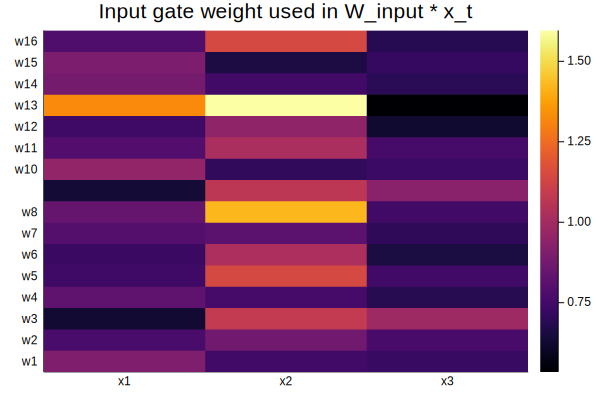

In [139]:
#+
xs = [string("x", i) for i = 1:3]
ys = [string("w", i) for i = 1:16]
heatmap(xs, ys, model_16.lstm.w[16+1:16*2, 17:19], title="Input gate weight used in W_input * x_t")

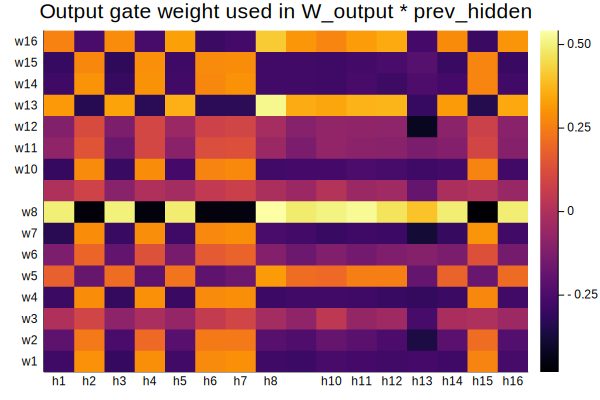

In [141]:
#+
xs = [string("h", i) for i = 1:16]
ys = [string("w", i) for i = 1:16]
heatmap(xs, ys, model_16.lstm.w[16*2+1:16*3, 1:16], title="Output gate weight used in W_output * prev_hidden")

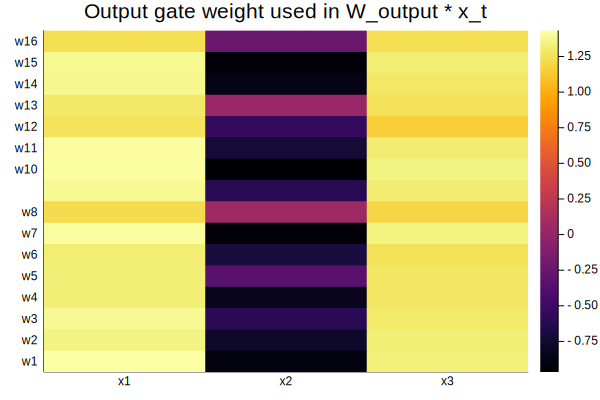

In [143]:
#+
xs = [string("x", i) for i = 1:3]
ys = [string("w", i) for i = 1:16]
heatmap(xs, ys, model_16.lstm.w[16*2+1:16*3, 17:19], title="Output gate weight used in W_output * x_t")

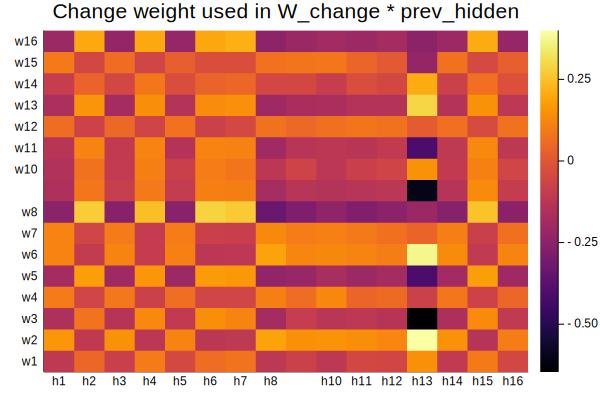

In [144]:
#+
xs = [string("h", i) for i = 1:16]
ys = [string("w", i) for i = 1:16]
heatmap(xs, ys, model_16.lstm.w[16*3+1:16*4, 1:16], title="Change weight used in W_change * prev_hidden")

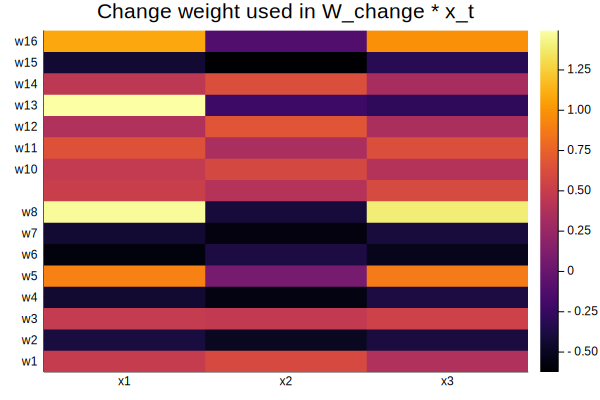

In [147]:
#+
xs = [string("x", i) for i = 1:3]
ys = [string("w", i) for i = 1:16]
heatmap(xs, ys, model_16.lstm.w[16*3+1:16*4, 17:19], title="Change weight used in W_change * x_t")

In [150]:
model_16.lstm.b

64-element Param{Array{Float64,1}}:
  0.8194337337889472 
  0.8710684005499169 
  0.9399266625954908 
  0.8479569290665868 
  0.7917276339001935 
  0.8630119285666243 
  0.8571877758166793 
  0.6064573170937586 
  0.9346761837640095 
  0.8159188526493156 
  0.867645285250866  
  1.0378886206776237 
  1.2146123562754527 
  ⋮                  
  0.4269651019841145 
 -0.4282089519090321 
 -0.42024923307605466
  0.5140579998867325 
  0.4581948310330199 
  0.4544803349196913 
  0.4636030532879851 
  0.444178741458893  
  0.06145682009161991
  0.449765274956828  
 -0.41914545625052196
  0.41231432795592177

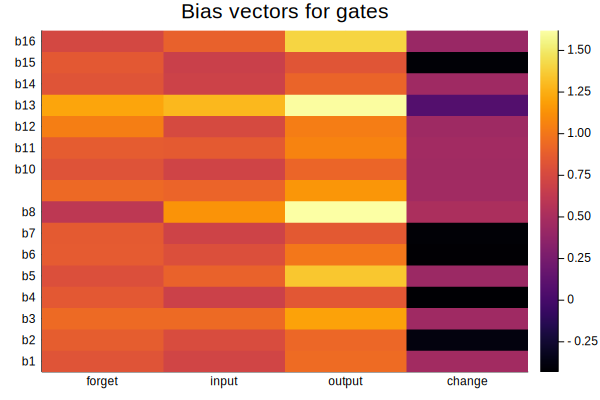

In [153]:
#+
xs = ["forget", "input", "output", "change"]
ys = [string("b", i) for i = 1:16]
heatmap(xs, ys, reshape(model_16.lstm.b, (16,4)), title="Bias vectors for gates")

In [155]:
# Final version 24.05

Now discuss the findings from the figures. You can further inspect the model to find the treasure hidden in the model.

Your Comment: There are some patterns especially in x1 and x3 in "Output gate weight used in W_output * x_t". We again see similar setting in "Input gate weight used in W_input * x_t" and "Forget gate weight used in W_forget * x_t". Similarly, three plots for prev hidden have almost same pattern.

